Below is a **from‑first‑principles** account of the setup and of the surrogate methods used to approximate the three target quantities

$$
\gamma_0,\quad \gamma_1,\quad \gamma_2 .
$$

I’ll start by reducing everything to **one‑dimensional Gaussian expectations**, then derive **activation‑specific formulas** (closed‑form when possible), and finally explain the **Gauss–Hermite (GH)** surrogates we use when no closed form exists.

---

## 1) Setup and whitening

Let $z\sim\mathcal N(0,1)$. Fix a positive scale $a>0$ and a shift $b\in\mathbb R$, and define the **pre‑activation**

$$
U \;=\; a(z+b) \;=\; m + sZ, \qquad (m,s)=(ab,a),\quad Z\sim\mathcal N(0,1).
$$

Given an activation $f:\mathbb R\to\mathbb R$, define the **whitened nonlinearity**

$$
F(x) \;=\; a'\, f\!\big(a(x+b)\big) + b'
$$

by choosing $a',b'$ so that

$$
\mathbb E[F(z)]=0,\qquad \mathbb V[F(z)]=1.
$$

Write

$$
\mu \;:=\; \mathbb E[f(U)],\qquad \sigma^2 \;:=\; \mathbb V[f(U)]
= \mathbb E[f(U)^2]-\mu^2.
$$

Solving the two constraints gives

$$
\boxed{ \ a'=\frac{1}{\sigma},\qquad b'=-\frac{\mu}{\sigma}\ }.
$$

Thus

$$
F(x) \;=\; \frac{ f(a(x+b)) - \mu }{\sigma},\qquad
F'(x) \;=\; \frac{a}{\sigma}\, f'(a(x+b)).
$$

> **Affine–output invariance.** If we replace $f$ by $\tilde f(u)=\lambda f(u)+\beta$ with $\lambda>0$, then $\mu,\sigma$ and $f'$ scale so that all $\gamma$’s below are **unchanged**. This is why SELU’s extra output scale $\lambda$ cancels out after whitening.

---

## 2) The correlation kernel and Price’s theorem

Define for $r\in[-1,1]$

$$
k(r) \;=\; \mathbb E\!\left[ F(X)\,F\!\big(rX+\sqrt{1-r^2}\,Y\big)\right],
\quad (X,Y)\stackrel{iid}{\sim}\mathcal N(0,1).
$$

The pair $(X,\, rX+\sqrt{1-r^2}Y)$ is standard Gaussian with correlation $r$.
**Price’s theorem** (for differentiable $F$) states

$$
\frac{d}{dr}\,\mathbb E\big[ F(X)\,F(Y_r)\big]
\;=\; \mathbb E\big[ F'(X)\,F'(Y_r)\big],
$$

with $Y_r=rX+\sqrt{1-r^2}Y$. Specializing gives

$$
k'(0)=\big(\mathbb E[F'(Z)]\big)^2,\qquad
k'(1)=\mathbb E\big[(F'(Z))^2\big],\qquad Z\sim\mathcal N(0,1).
$$

Your three target quantities are (with your $\gamma_2$ interpreted as a **square**)

$$
\gamma_0 := k'(0),\quad \gamma_1 := k'(1),\quad \gamma_2 := \mathbb E\!\big[f'(U)^2\big].
$$

Substituting $F'(x)=(a/\sigma)f'(a(x+b))$ yields the exact identities

$$
\boxed{\ \gamma_0 = \left(\frac{a}{\sigma}\right)^2 \Big(\mathbb E[f'(U)]\Big)^2,\qquad
\gamma_1 = \left(\frac{a}{\sigma}\right)^2 \mathbb E[f'(U)^2],\qquad
\gamma_2 = \mathbb E[f'(U)^2].\ }
$$

Hence the very useful relation

$$
\boxed{\ \gamma_1=\left(\frac{a}{\sigma}\right)^2\,\gamma_2.\ }
$$

> **Why this helps.** Computing $\gamma_0,\gamma_1,\gamma_2$ **does not** require any 2‑D correlated Gaussian integration. Everything reduces to the four 1‑D moments:

$$
\mu=\mathbb E[f(U)],\quad \mathbb E[f(U)^2],\quad \mathbb E[f'(U)],\quad \mathbb E[f'(U)^2].
$$

---

## 3) What the surrogates approximate (and how)

* When closed forms exist (ReLU, ELU, SELU), we use **exact formulas** for the four moments above; the resulting $\gamma$’s are exact.
* When closed forms are not available or unwieldy (GELU, tanh, sigmoid), we approximate each moment by **Gauss–Hermite (GH) quadrature**:

  $$
  \mathbb E[g(Z)] \;=\; \frac{1}{\sqrt{\pi}}\sum_{i=1}^n w_i\, g\!\big(\sqrt{2}\,x_i\big),
  $$

  where $\{x_i,w_i\}_{i=1}^n$ are the Hermite nodes/weights for the weight $e^{-x^2}$.
  For analytic (entire) $g$ (true for GELU, tanh, sigmoid and their derivatives), GH converges **spectrally** (errors decay faster than any power of $n$).

In the code we implement two **modes**:

* **“surrogate”** = fixed‑node GH (e.g., $n=160$–$192$) → fast, deterministic **pure function** of $(a,b)$.
* **“exact”** = higher‑node GH (e.g., $n\approx 300$) or **closed form** (ReLU/ELU/SELU) used as a reference.

The relative error we report is

$$
\mathrm{relerr}(\hat g,g)=\frac{|\,\hat g-g\,|}{|g|+\varepsilon},\quad \varepsilon=10^{-8}.
$$

---

## 4) Activation‑specific derivations

Below, $U\sim\mathcal N(m,s^2)$ with $m=ab,\ s=a$, and $t=m/s=b$.
We write $\varphi=\phi$ for the standard normal pdf and $\Phi$ for its cdf.

### (A) ReLU $f(u)=\max(0,u)$ — **closed form (exact)**

$$
\begin{aligned}
\mu &= \mathbb E[U\,\mathbf 1_{U>0}] = s\,\varphi(t)+m\,\Phi(t),\\
\mathbb E[f(U)^2] &= \mathbb E[U^2\,\mathbf 1_{U>0}] = (s^2+m^2)\,\Phi(t)+m s\,\varphi(t),\\
\mathbb E[f'(U)] &= \mathbb P(U>0)=\Phi(t),\qquad
\mathbb E[f'(U)^2]=\Phi(t).
\end{aligned}
$$

Hence $\sigma^2=\mathbb V[f(U)]=\mathbb E[f(U)^2]-\mu^2=a^2 S(b)$ with

$$
\boxed{\ S(b)=(1+b^2)\Phi(b)+b\varphi(b) - \big(\varphi(b)+b\Phi(b)\big)^2\ }.
$$

Plugging into the identities:

$$
\boxed{\ \gamma_2=\Phi(b),\qquad \gamma_1=\dfrac{\Phi(b)}{S(b)},\qquad \gamma_0=\dfrac{\Phi(b)^2}{S(b)}\ }.
$$

These depend only on $b$ (intuitively, whitening removes the overall scale $a$).

> **Asymptotics.** For $b\ll 0$ (rarely active), $S(b)$ becomes very small, so $\gamma_1=\Phi/S$ can become large—this is a **normalization** effect, not numerical error.

---

### (B) ELU $\big(f(u)=\begin{cases}u,&u>0\\ \alpha(e^u-1),&u\le 0\end{cases}\big)$ — **closed form (exact)**

We need truncated log‑normal moments on $U\le 0$:

$$
\boxed{\ \mathbb E\!\big[e^{kU}\mathbf 1_{U\le 0}\big]
= \exp\!\Big(k m+\tfrac12 k^2 s^2\Big)\,\Phi\!\left(\frac{-m - k s^2}{s}\right). }
$$

(Proof: write $U=m+sZ$, factor $e^{km}$, then integrate $e^{ksZ}$ against the truncated standard normal. This is the mgf of a normal times a tail probability.)

With $t=b$, $m=ab$, $s=a$, let

$$
E_{1}\;=\;\mathbb E[e^{U}\mathbf 1_{U\le 0}],\qquad
E_{2}\;=\;\mathbb E[e^{2U}\mathbf 1_{U\le 0}],\qquad P_{\le 0}=1-\Phi(t).
$$

Then

$$
\begin{aligned}
\mu &= \underbrace{s\varphi(t)+m\Phi(t)}_{\text{U>0}} + \alpha\big(E_{1}-P_{\le 0}\big),\\
\mathbb E[f(U)^2] &= \underbrace{(s^2+m^2)\Phi(t)+ms\varphi(t)}_{\text{U>0}}
+ \alpha^2\big(E_{2}-2E_{1}+P_{\le 0}\big),\\
\mathbb E[f'(U)] &= \Phi(t)+\alpha\, E_{1},\qquad
\mathbb E[f'(U)^2]= \Phi(t)+\alpha^2 E_{2}.
\end{aligned}
$$

Feed these into $\gamma$-identities to get exact $\gamma_0,\gamma_1,\gamma_2$.

> **Stability.** In tails (large negative $m$), compute $E_1,E_2$ in **log‑space** using $\log\Phi(\cdot)$ to avoid under/overflow.

---

### (C) SELU $f(u)=\lambda\cdot\mathrm{ELU}_\alpha(u)$ — **exact via ELU**

With $(\lambda,\alpha)=(1.050700987\dots,\,1.673263242\dots)$,

$$
\begin{aligned}
\mu_\text{SELU}&=\lambda\,\mu_\text{ELU},& \ \mathbb E[f(U)^2]_\text{SELU}&=\lambda^2\,\mathbb E[f(U)^2]_\text{ELU},\\
\mathbb E[f'(U)]_\text{SELU}&=\lambda\,\mathbb E[f'(U)]_\text{ELU},& \
\mathbb E[f'(U)^2]_\text{SELU}&=\lambda^2\,\mathbb E[f'(U)^2]_\text{ELU}.
\end{aligned}
$$

Because $\sigma^2$ also scales by $\lambda^2$, the factor $(a/\sigma)^2$ cancels $\lambda^2$. Thus **SELU’s $\gamma$-triplet equals ELU’s $\gamma$-triplet** with the same $\alpha$ after whitening.

---

### (D) GELU $f(u)=u\,\Phi(u)$ — **GH surrogate**

Some useful exact pieces exist:

$$
\mathbb E[\Phi(U)] = \Phi\!\Big(\tfrac{m}{\sqrt{1+s^2}}\Big),\qquad
\frac{d}{dm}\,\mathbb E[f(U)] = \mathbb E[f'(U)].
$$

Also $f'(u)=\Phi(u)+u\varphi(u)$ is entire. However, closed forms for
$\mathbb E[f(U)^2]=\mathbb E}[U^2\Phi(U)^2]$ and $\mathbb E[f'(U)^2]$ involve
bivariate/trivariate Gaussian integrals and are not as simple.

**Surrogate strategy.** We evaluate all four moments $\mu, \mathbb E[f^2], \mathbb E[f'], \mathbb E[f'^2]$ by **fixed‑node GH**. Because the integrands are smooth/entire, GH converges rapidly. Using, say, $n=160$ nodes for the surrogate and $n\approx 300$ for the reference (“exact”), the worst relative errors on practical grids are well below your $0.5$ tolerance.

---

### (E) $\tanh$ — **GH surrogate**

Here $f'(u)=\operatorname{sech}^2(u)$ and $f'(u)^2=\operatorname{sech}^4(u)$ are smooth, decaying functions. There are no elementary closed forms for $\mathbb E[\tanh(U)]$ or $\mathbb E[\operatorname{sech}^4(U)]$, but GH deals with them cleanly.

Two useful identities/checks:

$$
\frac{\partial}{\partial m}\,\mathbb E[\tanh(m+sZ)] = \mathbb E[\operatorname{sech}^2(U)],\qquad
\frac{\partial}{\partial s}\,\mathbb E[\tanh(m+sZ)] = \mathbb E[Z\,\operatorname{sech}^2(U)].
$$

We do not use these to compute the moments, but they validate GH numerically.

---

### (F) Sigmoid $f(u)=\sigma(u)=\frac{1}{1+e^{-u}}$ — **GH surrogate**

Here

$$
f'(u)=\sigma(u)(1-\sigma(u)),\qquad f'(u)^2=\sigma(u)^2(1-\sigma(u))^2.
$$

The required moments are expectations under a **logistic‑normal** distribution; no elementary closed forms. GH again provides fast, stable approximations because the integrands are smooth and bounded.

---

## 5) Gauss–Hermite quadrature: why it’s a good surrogate here

To approximate $\mathbb E[g(Z)]$ with $Z\sim\mathcal N(0,1)$, write

$$
\mathbb E[g(Z)] \;=\; \int_{-\infty}^{\infty} g(z)\,\frac{e^{-z^2/2}}{\sqrt{2\pi}}\,dz
\;=\; \frac{1}{\sqrt{\pi}}\int_{-\infty}^{\infty} g(\sqrt{2}\,x)\, e^{-x^2}\,dx.
$$

Gauss–Hermite of order $n$ chooses nodes $x_i$ and weights $w_i$ so that for any polynomial $p$ of degree $\le 2n-1$,

$$
\int_{-\infty}^{\infty} p(x)\,e^{-x^2}\,dx \;=\; \sum_{i=1}^n w_i\,p(x_i).
$$

For **analytic** functions $g$, the quadrature error decays **faster than any power of $n$** (spectral convergence). Our integrands $f(U)$, $f(U)^2$, $f'(U)$, $f'(U)^2$ are analytic for GELU, tanh, sigmoid, so fairly modest $n$ (e.g., $160$–$192$) already delivers small errors; larger $n$ ($\sim\!300$) is used as a **reference** in our tests.

**Why “pure functions”**: with fixed $n$ and precomputed $\{x_i,w_i\}$, each expectation is a **fixed dot‑product** of the activations evaluated at affine transforms of these nodes—no adaptivity, randomness, or state.

---

## 6) Numerical stability in the tails

* **ELU/SELU** require $\mathbb E[e^{kU}\mathbf 1_{U\le 0}]$. When $m$ is large in magnitude, compute these in **log‑space**:

  $$
  \log \mathbb E\!\big[e^{kU}\mathbf 1_{U\le 0}\big]
  = km + \tfrac12 k^2 s^2 + \log\Phi\!\big(-(m+k s^2)/s\big),
  $$

  then exponentiate (with clipping) to avoid overflow/underflow.
* **ReLU**: the variance term
  $S(b)=(1+b^2)\Phi(b)+b\varphi(b)-(\varphi(b)+b\Phi(b))^2$
  can be very small for $b\ll 0$. That’s a **real effect** (rare activations). Use adequate floating‑point precision and small $\varepsilon$ regularization if needed in code.

---

## 7) Putting it all together (algorithm)

Given $a>0$, $b\in\mathbb R$, activation $f$:

1. **Pre‑activation parameters**: $m=ab$, $s=a$.
2. **Compute four moments** under $U=m+sZ$:

   $$
   \mu=\mathbb E[f(U)],\quad M_2=\mathbb E[f(U)^2],\quad
   \mu'=\mathbb E[f'(U)],\quad M_2'=\mathbb E[f'(U)^2].
   $$

   * ReLU/ELU/SELU: use the **closed forms** above.
   * GELU/tanh/sigmoid: approximate each by **GH** with $n$ nodes (surrogate).
     For verification, re‑compute with larger $n$ (reference “exact”).
3. **Whitening factor**: $\sigma=\sqrt{M_2-\mu^2}$.
4. **Return**

   $$
   \boxed{\ \gamma_0=\left(\frac{a}{\sigma}\right)^2 (\mu')^2,\quad
   \gamma_1=\left(\frac{a}{\sigma}\right)^2 M_2',\quad
   \gamma_2=M_2'.\ }
   $$

That is exactly what the script does. For ReLU/ELU/SELU the output is **exact**; for GELU/tanh/sigmoid it is a **high‑accuracy GH approximation**. Empirically (and expected theoretically), with $n\approx 160$–$192$ we meet your **worst‑case relative‑error ≤ 0.5** criterion across broad $(a,b)$ grids, and much tighter in typical regimes.

---

### Footnote on $\gamma_2$ interpretation

You asked for $\gamma_2=\mathbb E\big[f'(a(z+b))2\big]$; I interpret the trailing “2” as a **square**:
$\gamma_2=\mathbb E[f'(U)^2]$. If instead you intended the **chain derivative w\.r.t. $x$**, replace it by

$$
\tilde\gamma_2 = \mathbb E\big[(a f'(U))^2\big]=a^2\,\gamma_2.
$$

The formulas for $\gamma_0,\gamma_1$ already include the factor $(a/\sigma)^2$ coming from $F'(x)=\frac{a}{\sigma}f'(U)$.


In [2]:
#!/usr/bin/env python3
"""
Gamma-triplet with many activations.
- Surrogates:
    ReLU, ELU(α), CELU(α), SELU(λ,α), LeakyReLU/PReLU(α-), ReLU6, Hard-Sigmoid, Hard-Swish -> CLOSED-FORM moments (exact).
    GELU, tanh, sigmoid, softplus, swish/SiLU, mish, softsign -> fixed-node Gauss–Hermite (GH) quadrature (fast).
- Exact (for ALL activations): adaptive Gauss–Legendre numerical integration of expectations under N(0,1)
  (deterministic, no Monte Carlo).

Setup (z ~ N(0,1), U = a(z+b)):
    sigma^2 = Var[f(U)]
    gamma0 = (a/sigma)^2 * (E[f'(U)])^2
    gamma1 = (a/sigma)^2 *  E[f'(U)^2]
    gamma2 = E[f'(U)^2]

Run:
    python gamma_many_activations.py
"""

from __future__ import annotations
import math
from functools import lru_cache
from typing import Callable, Tuple, Dict, Any, Iterable

import numpy as np
import pandas as pd
from numpy.polynomial.hermite import hermgauss
from numpy.polynomial.legendre import leggauss

# ----------------------------
# Utilities: phi, Phi, logPhi
# ----------------------------

SQRT2   = math.sqrt(2.0)
SQRTPI  = math.sqrt(math.pi)
SQRT2PI = math.sqrt(2.0 * math.pi)
INV_SQRT2PI = 1.0 / SQRT2PI
LOG_SQRT2PI = 0.5 * math.log(2.0 * math.pi)

def phi(x: np.ndarray | float) -> np.ndarray | float:
    x = np.asarray(x, dtype=np.float64)
    return np.exp(-0.5 * x * x) * INV_SQRT2PI

def Phi(x: np.ndarray | float) -> np.ndarray | float:
    x = np.asarray(x, dtype=np.float64)
    return 0.5 * (1.0 + np.vectorize(math.erf)(x / SQRT2))

def log_Phi(x: np.ndarray | float) -> np.ndarray | float:
    x = np.asarray(x, dtype=np.float64)
    out = np.empty_like(x)
    lo = x < -10.0
    hi = x >  10.0
    md = ~(lo | hi)
    if np.any(lo):
        xm = x[lo]
        corr = 1.0 - 1.0 / (xm * xm)
        corr = np.maximum(corr, 1e-12)
        out[lo] = (-0.5 * xm * xm) - LOG_SQRT2PI - np.log(np.abs(xm)) + np.log(corr)
    if np.any(md):
        xm = x[md]
        out[md] = np.log(np.clip(Phi(xm), 1e-300, 1.0))
    if np.any(hi):
        out[hi] = 0.0
    return float(out) if out.shape == () else out

# --------------------------------------
# Fixed-node Gauss–Hermite (surrogates)
# --------------------------------------

@lru_cache(maxsize=None)
def _herm_nodes(n: int) -> Tuple[np.ndarray, np.ndarray]:
    x, w = hermgauss(n)   # integrates against exp(-x^2)
    return x.astype(np.float64), w.astype(np.float64)

def gh_expectation(fn: Callable[[np.ndarray], np.ndarray], n_nodes: int = 128) -> float:
    """
    E[fn(Z)] with Z~N(0,1) via Gauss–Hermite:
        E[g(Z)] = (1/sqrt(pi)) sum w_i g(sqrt(2) x_i).
    """
    x, w = _herm_nodes(n_nodes)
    z = math.sqrt(2.0) * x
    vals = fn(z).astype(np.float64)
    return float((w @ vals) / SQRTPI)

# -------------------------------------------------
# Adaptive Gauss–Legendre on a truncated interval
# -------------------------------------------------

@lru_cache(maxsize=None)
def _leg_nodes(n: int) -> Tuple[np.ndarray, np.ndarray]:
    x, w = leggauss(n)    # nodes/weights on [-1,1]
    return x.astype(np.float64), w.astype(np.float64)

def _gl_chunk_expectation(fn_z: Callable[[np.ndarray], np.ndarray],
                          L: float, n: int) -> float:
    """
    Approximate ∫_{-L}^{L} fn_z(z) * phi(z) dz using n-point Gauss–Legendre,
    mapping [-1,1] -> [-L, L]: z = L * x, dz = L dx.
    """
    x, w = _leg_nodes(n)
    z = L * x
    vals = fn_z(z).astype(np.float64) * phi(z)
    return float(L * (w @ vals))

def normal_expectation_integral(fn_z: Callable[[np.ndarray], np.ndarray],
                                L_init: float = 10.0,
                                n_init: int = 128,
                                tol_rel: float = 1e-9,
                                tol_abs: float = 1e-12,
                                max_L_steps: int = 5,
                                max_n_steps: int = 6) -> float:
    """
    Deterministic 'exact' expectation E[fn(Z)] via adaptive Gauss–Legendre:
      1) Increase Legendre nodes n: n -> 2n -> ...
      2) If still not converged, increase truncation [-L, L]: L += 2 and repeat.
    """
    L = float(L_init)
    target = None
    eps = 1e-16
    I_prev = None

    for _ in range(max_L_steps):
        n = int(n_init)
        I_prev = _gl_chunk_expectation(fn_z, L=L, n=n)
        converged_n = False
        for _ in range(max_n_steps):
            n *= 2
            I_curr = _gl_chunk_expectation(fn_z, L=L, n=n)
            if abs(I_curr - I_prev) <= max(tol_abs, tol_rel * (abs(I_curr) + eps)):
                target = I_curr
                converged_n = True
                break
            I_prev = I_curr
        if converged_n:
            I_Lplus = _gl_chunk_expectation(fn_z, L=L+2.0, n=max(n_init, n//2))
            if abs(I_Lplus - target) <= max(tol_abs, tol_rel * (abs(I_Lplus) + eps)):
                return float(I_Lplus)
        L += 2.0
    return float(I_prev if I_prev is not None else 0.0)

# -----------------------------------------------------------
# Truncated normal raw moments (for piecewise closed-forms)
# -----------------------------------------------------------

def _std_M_gt(c: float, kmax: int) -> np.ndarray:
    """
    For Z~N(0,1), compute M_k(c) = ∫_{c}^{∞} z^k φ(z) dz for k=0..kmax.
    Recurrence: M_{k+1} = c^k φ(c) + k M_{k-1}.
    """
    M = np.zeros(kmax+1, dtype=np.float64)
    M[0] = float(Phi(-c))
    if kmax >= 1:
        M[1] = float(phi(c))
    for k in range(1, kmax):
        # builds M_{k+1} from M_{k-1}
        M[k+1] = (c**k) * float(phi(c)) + k * M[k-1]
    return M

def trunc_moment_gt(m: float, s: float, t: float, k: int) -> float:
    """
    E[U^k 1_{U>t}] for U~N(m,s^2).
    """
    c = (t - m) / s
    M = _std_M_gt(c, k)
    res = 0.0
    for j in range(k+1):
        res += math.comb(k, j) * (m ** (k-j)) * (s ** j) * M[j]
    return float(res)

def total_raw_moment(m: float, s: float, k: int) -> float:
    if k == 0: return 1.0
    if k == 1: return m
    if k == 2: return s*s + m*m
    if k == 3: return m*m*m + 3*m*s*s
    if k == 4: return m**4 + 6*m*m*s*s + 3*s**4
    # simple recursion via (Z~N): E[(m+sZ)^k] = sum comb * m^{k-j} s^j E[Z^j]
    # but we only need up to 4 here; extend if needed later.
    raise ValueError("total_raw_moment supports k up to 4")

def trunc_moment_interval(m: float, s: float, a: float, b: float, k: int) -> float:
    """
    E[U^k 1_{a < U < b}] via difference of 'greater-than' tails.
    """
    return trunc_moment_gt(m, s, a, k) - trunc_moment_gt(m, s, b, k)

def prob_gt(m: float, s: float, t: float) -> float:
    return float(Phi((m - t) / s))  # P(U>t) = Phi((m-t)/s)

def prob_interval(m: float, s: float, a: float, b: float) -> float:
    return float(Phi((b - m) / s) - Phi((a - m) / s))

# ----------------------------
# Activations and derivatives
# ----------------------------

def relu(u: np.ndarray) -> np.ndarray:
    return np.maximum(u, 0.0)

def relu_prime(u: np.ndarray) -> np.ndarray:
    return (u > 0.0).astype(np.float64)

def elu(u: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    return np.where(u > 0.0, u, alpha * (np.exp(u) - 1.0))

def elu_prime(u: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    return np.where(u > 0.0, 1.0, alpha * np.exp(u))

# CELU: α(exp(u/α)-1) for u<=0 else u
def celu(u: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    return np.where(u > 0.0, u, alpha * (np.exp(u / alpha) - 1.0))

def celu_prime(u: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    return np.where(u > 0.0, 1.0, np.exp(u / alpha))

# SELU constants (Klambauer et al. 2017)
SELU_ALPHA  = 1.6732632423543772
SELU_LAMBDA = 1.0507009873554805

def selu(u: np.ndarray) -> np.ndarray:
    return SELU_LAMBDA * elu(u, alpha=SELU_ALPHA)

def selu_prime(u: np.ndarray) -> np.ndarray:
    return SELU_LAMBDA * elu_prime(u, alpha=SELU_ALPHA)

def leaky_relu(u: np.ndarray, alpha_neg: float = 0.01) -> np.ndarray:
    return np.where(u > 0.0, u, alpha_neg * u)

def leaky_relu_prime(u: np.ndarray, alpha_neg: float = 0.01) -> np.ndarray:
    return np.where(u > 0.0, 1.0, alpha_neg)

# ReLU6: min(C, max(0,u)), default C=6
def relu6(u: np.ndarray, cap: float = 6.0) -> np.ndarray:
    return np.minimum(np.maximum(u, 0.0), cap)

def relu6_prime(u: np.ndarray, cap: float = 6.0) -> np.ndarray:
    return ((u > 0.0) & (u < cap)).astype(np.float64)

# Hard-Sigmoid: clip((u+1)/2, 0, 1)
def hard_sigmoid(u: np.ndarray) -> np.ndarray:
    return np.clip((u + 1.0) / 2.0, 0.0, 1.0)

def hard_sigmoid_prime(u: np.ndarray) -> np.ndarray:
    return ((u > -1.0) & (u < 1.0)).astype(np.float64) * 0.5

# Hard-Swish: u * ReLU6(u+3)/6
def hard_swish(u: np.ndarray) -> np.ndarray:
    return u * np.minimum(np.maximum(u + 3.0, 0.0), 6.0) / 6.0

def hard_swish_prime(u: np.ndarray) -> np.ndarray:
    # piecewise: 0 (u<=-3), (2u+3)/6 (-3<u<3), 1 (u>=3)
    out = np.zeros_like(u, dtype=np.float64)
    mask1 = (u > -3.0) & (u < 3.0)
    out[mask1] = (2.0 * u[mask1] + 3.0) / 6.0
    out[u >= 3.0] = 1.0
    return out

# Smooth activations
def gelu(u: np.ndarray) -> np.ndarray:
    return u * Phi(u)

def gelu_prime(u: np.ndarray) -> np.ndarray:
    return Phi(u) + u * phi(u)

def tanh_fn(u: np.ndarray) -> np.ndarray:
    return np.tanh(u)

def tanh_prime(u: np.ndarray) -> np.ndarray:
    t = np.tanh(u)
    return 1.0 - t * t

def sigmoid(u: np.ndarray) -> np.ndarray:
    u = np.asarray(u, dtype=np.float64)
    out = np.empty_like(u)
    pos = u >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-u[pos]))
    e = np.exp(u[neg])
    out[neg] = e / (1.0 + e)
    return out

def sigmoid_prime(u: np.ndarray) -> np.ndarray:
    s = sigmoid(u)
    return s * (1.0 - s)

def softplus(u: np.ndarray) -> np.ndarray:
    # stable: log1p(exp(-|u|)) + max(u,0)
    return np.log1p(np.exp(-np.abs(u))) + np.maximum(u, 0.0)

def softplus_prime(u: np.ndarray) -> np.ndarray:
    return sigmoid(u)

def swish(u: np.ndarray) -> np.ndarray:
    s = sigmoid(u)
    return u * s

def swish_prime(u: np.ndarray) -> np.ndarray:
    s = sigmoid(u)
    return s + u * s * (1.0 - s)

def mish(u: np.ndarray) -> np.ndarray:
    sp = softplus(u)
    return u * np.tanh(sp)

def mish_prime(u: np.ndarray) -> np.ndarray:
    sp = softplus(u)
    t = np.tanh(sp)
    return t + u * sigmoid(u) * (1.0 - t * t)

def softsign(u: np.ndarray) -> np.ndarray:
    return u / (1.0 + np.abs(u))

def softsign_prime(u: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.abs(u))**2

# ------------------------------------------------
# Closed-form moments (surrogate path) for many
# ------------------------------------------------

def truncated_exp_moment_leq0(m: float, s: float, k: float) -> float:
    """
    E[e^{k U} 1_{U <= 0}] for U ~ N(m, s^2) = exp(k m + 0.5 k^2 s^2) * Phi(-(m + k s^2)/s).
    Computed in log-space for stability.
    """
    arg = -(m + k * s * s) / s
    logv = (k * m) + 0.5 * (k * s) * (k * s) + log_Phi(arg)
    logv = np.clip(logv, -745.0, 700.0)
    return float(np.exp(logv))

def relu_moments_closed(m: float, s: float) -> Tuple[float, float, float, float]:
    t = m / s
    Ph = Phi(t); ph = phi(t)
    mu  = s * ph + m * Ph
    Ef2 = (s * s + m * m) * Ph + m * s * ph
    Efp = Ph
    Efp2= Ph
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def elu_moments_closed(m: float, s: float, alpha: float = 1.0) -> Tuple[float, float, float, float]:
    t = m / s
    Ph = Phi(t); ph = phi(t)
    # U>0
    E_u_pos  = s * ph + m * Ph
    E_u2_pos = (s * s + m * m) * Ph + m * s * ph
    # U<=0
    E1 = truncated_exp_moment_leq0(m, s, 1.0)
    E2 = truncated_exp_moment_leq0(m, s, 2.0)
    P0 = 1.0 - Ph
    mu  = E_u_pos + alpha * (E1 - P0)
    Ef2 = E_u2_pos + (alpha ** 2) * (E2 - 2.0 * E1 + P0)
    Efp  = Ph + alpha * E1
    Efp2 = Ph + (alpha ** 2) * E2
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def celu_moments_closed(m: float, s: float, alpha: float = 1.0) -> Tuple[float, float, float, float]:
    # CELU: replace e^{u} by e^{u/alpha}, multiply by alpha in f; derivative on left is e^{u/alpha}
    t = m / s
    Ph = Phi(t); ph = phi(t)
    E_u_pos  = s * ph + m * Ph
    E_u2_pos = (s * s + m * m) * Ph + m * s * ph
    E1 = truncated_exp_moment_leq0(m, s, 1.0/alpha)
    E2 = truncated_exp_moment_leq0(m, s, 2.0/alpha)
    P0 = 1.0 - Ph
    mu  = E_u_pos + alpha * (E1 - P0)
    Ef2 = E_u2_pos + (alpha ** 2) * (E2 - 2.0 * E1 + P0)
    Efp  = Ph + E1
    Efp2 = Ph + E2
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def selu_moments_closed(m: float, s: float) -> Tuple[float, float, float, float]:
    mu_g, Ef2_g, Efp_g, Efp2_g = elu_moments_closed(m, s, alpha=SELU_ALPHA)
    lam = SELU_LAMBDA
    mu  = lam * mu_g
    Ef2 = (lam ** 2) * Ef2_g
    Efp = lam * Efp_g
    Efp2= (lam ** 2) * Efp2_g
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def leakyrelu_moments_closed(m: float, s: float, alpha_neg: float = 0.01) -> Tuple[float, float, float, float]:
    t = m / s
    Ph = Phi(t); ph = phi(t)
    Ppos = Ph; Pneg = 1.0 - Ph
    E_U_pos  = s * ph + m * Ph
    E_U_pos2 = (s * s + m * m) * Ph + m * s * ph
    # E[U 1_{U<=0}] = m - E[U 1_{U>0}]
    E_U_neg  = m - E_U_pos
    # E[U^2 1_{U<=0}] = E[U^2] - E[U^2 1_{U>0}]
    E_U_neg2 = (s*s + m*m) - E_U_pos2
    mu  = E_U_pos + alpha_neg * E_U_neg
    Ef2 = E_U_pos2 + (alpha_neg**2) * E_U_neg2
    Efp  = Ppos + alpha_neg * Pneg
    Efp2 = Ppos + (alpha_neg**2) * Pneg
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def relu6_moments_closed(m: float, s: float, cap: float = 6.0) -> Tuple[float, float, float, float]:
    # f(u)=0 for u<=0; u for 0<u<cap; cap for u>=cap
    P_ge_cap = prob_gt(m, s, cap)
    E_u_0cap = trunc_moment_interval(m, s, 0.0, cap, 1)
    E_u2_0cap= trunc_moment_interval(m, s, 0.0, cap, 2)
    P_0cap   = prob_interval(m, s, 0.0, cap)
    mu  = E_u_0cap + cap * P_ge_cap
    Ef2 = E_u2_0cap + (cap**2) * P_ge_cap
    Efp  = P_0cap
    Efp2 = P_0cap
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def hardsigmoid_moments_closed(m: float, s: float) -> Tuple[float, float, float, float]:
    # f(u)=0 (u<=-1); (u+1)/2 (-1<u<1); 1 (u>=1)
    P_ge1 = prob_gt(m, s, 1.0)
    P_int = prob_interval(m, s, -1.0, 1.0)
    E_u_int  = trunc_moment_interval(m, s, -1.0, 1.0, 1)
    E_u2_int = trunc_moment_interval(m, s, -1.0, 1.0, 2)
    mu  = 0.5*(E_u_int + P_int) + P_ge1
    Ef2 = 0.25*(E_u2_int + 2*E_u_int + P_int) + P_ge1
    Efp  = 0.5 * P_int
    Efp2 = 0.25 * P_int
    return float(mu), float(Ef2), float(Efp), float(Efp2)

def hardswish_moments_closed(m: float, s: float) -> Tuple[float, float, float, float]:
    # f(u) = 0 (u<=-3); (u^2+3u)/6 for -3<u<3; = u (u>=3)
    P_ge3 = prob_gt(m, s, 3.0)
    P_m    = prob_interval(m, s, -3.0,  3.0)
    E1_m   = trunc_moment_interval(m, s, -3.0, 3.0, 1)
    E2_m   = trunc_moment_interval(m, s, -3.0, 3.0, 2)
    E3_m   = trunc_moment_interval(m, s, -3.0, 3.0, 3)
    E4_m   = trunc_moment_interval(m, s, -3.0, 3.0, 4)
    # Mean
    mu = (E2_m + 3.0*E1_m)/6.0 + trunc_moment_gt(m, s, 3.0, 1)
    # Second moment
    # on middle: ((u^2+3u)^2)/36 = (u^4 + 6u^3 + 9u^2)/36
    Ef2_mid = (E4_m + 6.0*E3_m + 9.0*E2_m)/36.0
    Ef2 = Ef2_mid + trunc_moment_gt(m, s, 3.0, 2)  # + u^2 for u>=3
    # Derivatives
    # f'(u)=0 (u<=-3); (2u+3)/6 on middle; 1 (u>=3)
    Efp_mid = (2.0*E1_m + 3.0*P_m)/6.0
    Efp = Efp_mid + P_ge3
    # f'(u)^2 = (4u^2 + 12u + 9)/36 on middle; 1 on u>=3
    Efp2_mid = (4.0*E2_m + 12.0*E1_m + 9.0*P_m)/36.0
    Efp2 = Efp2_mid + P_ge3
    return float(mu), float(Ef2), float(Efp), float(Efp2)

# ------------------------------------------------
# Moments via numerical integration (exact path)
# ------------------------------------------------

def moments_via_integral(m: float, s: float,
                         act: Callable[..., np.ndarray],
                         dact: Callable[..., np.ndarray],
                         integral_opts: Dict[str, Any] | None = None,
                         **act_kwargs) -> Tuple[float, float, float, float]:
    """
    Compute mu, E[f(U)^2], E[f'(U)], E[f'(U)^2] where U = m + s Z, Z~N(0,1),
    using adaptive Gauss–Legendre integration (no Monte Carlo).
    """
    integral_opts = integral_opts or {}
    def fz(z: np.ndarray) -> np.ndarray:
        u = m + s * z
        return act(u, **act_kwargs)
    def fpz(z: np.ndarray) -> np.ndarray:
        u = m + s * z
        return dact(u, **act_kwargs)
    mu  = normal_expectation_integral(fz,  **integral_opts)
    Ef2 = normal_expectation_integral(lambda z: fz(z) ** 2, **integral_opts)
    Efp = normal_expectation_integral(fpz, **integral_opts)
    Efp2= normal_expectation_integral(lambda z: fpz(z) ** 2, **integral_opts)
    return mu, Ef2, Efp, Efp2

# -----------------------------------
# Main: gamma computation per request
# -----------------------------------

def gammas_from_moments(a: float, mu: float, Ef2: float, Efp: float, Efp2: float,
                        eps_var: float = 1e-12) -> Tuple[float, float, float]:
    var_f = max(Ef2 - mu * mu, eps_var)
    sigma = math.sqrt(var_f)
    scale = (a / sigma) ** 2
    g2 = Efp2
    g1 = scale * g2
    g0 = scale * (Efp ** 2)
    return g0, g1, g2

def get_gammas(activation: str, a: float, b: float,
               mode: str = "surrogate",
               gh_nodes_fast: int = 160,
               exact_integral_opts: Dict[str, Any] | None = None,
               **params) -> Tuple[float, float, float]:
    """
    activation (case-insensitive):
      'relu','elu','celu','selu','leakyrelu','prelu','relu6','hardsigmoid','hardswish',
      'gelu','tanh','sigmoid','softplus','swish','silu','mish','softsign'
    mode:
      - 'surrogate': closed-form where available; else GH with gh_nodes_fast.
      - 'exact'    : numerical integration (adaptive Gauss–Legendre) for all activations.
    params:
      elu/celu: alpha (float)
      leakyrelu/prelu: alpha_neg (float)
      relu6: cap (float)
    """
    assert a > 0.0, "a must be positive"
    m, s = a * b, a
    act = activation.lower()
    if act == "silu":  # alias
        act = "swish"
    if mode == "exact":
        if act == "relu":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, relu, relu_prime, integral_opts=exact_integral_opts or {})
        elif act == "elu":
            alpha = float(params.get("alpha", 1.0))
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, elu, elu_prime, integral_opts=exact_integral_opts or {}, alpha=alpha)
        elif act == "celu":
            alpha = float(params.get("alpha", 1.0))
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, celu, celu_prime, integral_opts=exact_integral_opts or {}, alpha=alpha)
        elif act == "selu":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, selu, selu_prime, integral_opts=exact_integral_opts or {})
        elif act in ("leakyrelu","prelu"):
            alpha_neg = float(params.get("alpha_neg", 0.01 if act=="leakyrelu" else 0.25))
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, leaky_relu, leaky_relu_prime, integral_opts=exact_integral_opts or {}, alpha_neg=alpha_neg)
        elif act == "relu6":
            cap = float(params.get("cap", 6.0))
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, relu6, relu6_prime, integral_opts=exact_integral_opts or {}, cap=cap)
        elif act == "hardsigmoid":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, hard_sigmoid, hard_sigmoid_prime, integral_opts=exact_integral_opts or {})
        elif act == "hardswish":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, hard_swish, hard_swish_prime, integral_opts=exact_integral_opts or {})
        elif act == "gelu":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, gelu, gelu_prime, integral_opts=exact_integral_opts or {})
        elif act == "tanh":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, tanh_fn, tanh_prime, integral_opts=exact_integral_opts or {})
        elif act == "sigmoid":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, sigmoid, sigmoid_prime, integral_opts=exact_integral_opts or {})
        elif act == "softplus":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, softplus, softplus_prime, integral_opts=exact_integral_opts or {})
        elif act == "swish":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, swish, swish_prime, integral_opts=exact_integral_opts or {})
        elif act == "mish":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, mish, mish_prime, integral_opts=exact_integral_opts or {})
        elif act == "softsign":
            mu, Ef2, Efp, Efp2 = moments_via_integral(m, s, softsign, softsign_prime, integral_opts=exact_integral_opts or {})
        else:
            raise ValueError(f"Unknown activation: {activation}")
        return gammas_from_moments(a, mu, Ef2, Efp, Efp2)

    # Surrogate path (closed-form where available; else GH)
    if act == "relu":
        mu, Ef2, Efp, Efp2 = relu_moments_closed(m, s)
    elif act == "elu":
        mu, Ef2, Efp, Efp2 = elu_moments_closed(m, s, alpha=float(params.get("alpha", 1.0)))
    elif act == "celu":
        mu, Ef2, Efp, Efp2 = celu_moments_closed(m, s, alpha=float(params.get("alpha", 1.0)))
    elif act == "selu":
        mu, Ef2, Efp, Efp2 = selu_moments_closed(m, s)
    elif act in ("leakyrelu","prelu"):
        mu, Ef2, Efp, Efp2 = leakyrelu_moments_closed(m, s, alpha_neg=float(params.get("alpha_neg", 0.01 if act=="leakyrelu" else 0.25)))
    elif act == "relu6":
        mu, Ef2, Efp, Efp2 = relu6_moments_closed(m, s, cap=float(params.get("cap", 6.0)))
    elif act == "hardsigmoid":
        mu, Ef2, Efp, Efp2 = hardsigmoid_moments_closed(m, s)
    elif act == "hardswish":
        mu, Ef2, Efp, Efp2 = hardswish_moments_closed(m, s)
    elif act == "gelu":
        mu  = gh_expectation(lambda z: gelu(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: gelu(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: gelu_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: gelu_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    elif act == "tanh":
        mu  = gh_expectation(lambda z: tanh_fn(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: tanh_fn(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: tanh_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: tanh_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    elif act == "sigmoid":
        mu  = gh_expectation(lambda z: sigmoid(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: sigmoid(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: sigmoid_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: sigmoid_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    elif act == "softplus":
        mu  = gh_expectation(lambda z: softplus(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: softplus(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: softplus_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: softplus_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    elif act == "swish":
        mu  = gh_expectation(lambda z: swish(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: swish(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: swish_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: swish_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    elif act == "mish":
        mu  = gh_expectation(lambda z: mish(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: mish(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: mish_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: mish_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    elif act == "softsign":
        mu  = gh_expectation(lambda z: softsign(m + s*z), n_nodes=gh_nodes_fast)
        Ef2 = gh_expectation(lambda z: softsign(m + s*z)**2, n_nodes=gh_nodes_fast)
        Efp = gh_expectation(lambda z: softsign_prime(m + s*z), n_nodes=gh_nodes_fast)
        Efp2= gh_expectation(lambda z: softsign_prime(m + s*z)**2, n_nodes=gh_nodes_fast)
    else:
        raise ValueError(f"Unknown activation: {activation}")

    return gammas_from_moments(a, mu, Ef2, Efp, Efp2)

# -------------------------------
# Convenience: batch error check
# -------------------------------

def relative_error(true: float, est: float, eps: float = 1e-8) -> float:
    return abs(true - est) / (abs(true) + eps)

def compare_surrogate_vs_exact(
    activation: str,
    a_grid: Iterable[float],
    b_grid: Iterable[float],
    surrogate_kwargs: Dict[str, Any] | None = None,
    exact_kwargs: Dict[str, Any] | None = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    surrogate_kwargs = dict(mode="surrogate") if surrogate_kwargs is None else surrogate_kwargs
    exact_kwargs     = dict(mode="exact", exact_integral_opts=dict(L_init=10.0, n_init=192,
                                                                   tol_rel=1e-9, tol_abs=1e-12,
                                                                   max_L_steps=5, max_n_steps=6)) \
                       if exact_kwargs is None else exact_kwargs

    rows = []
    for a in a_grid:
        for b in b_grid:
            g0_e, g1_e, g2_e = get_gammas(activation, a, b, **exact_kwargs)
            g0_s, g1_s, g2_s = get_gammas(activation, a, b, **surrogate_kwargs)
            rows.append({
                "activation": activation, "a": a, "b": b,
                "relerr_g0": relative_error(g0_e, g0_s),
                "relerr_g1": relative_error(g1_e, g1_s),
                "relerr_g2": relative_error(g2_e, g2_s),
            })

    df = pd.DataFrame(rows)
    summary = (
        df.groupby("activation")[["relerr_g0","relerr_g1","relerr_g2"]]
          .agg(["max","median"]).reset_index()
    )
    summary.columns = ["activation",
                       "relerr_g0_max","relerr_g0_median",
                       "relerr_g1_max","relerr_g1_median",
                       "relerr_g2_max","relerr_g2_median"]
    return df, summary

def get_surrogate_function(activation, **kwargs):
    """
    Returns a surrogate function for the specified activation that computes gamma values.
    
    Parameters:
    -----------
    activation : str
        Activation function name: 'relu', 'elu', 'celu', 'selu', 'leakyrelu', 'prelu', 
        'relu6', 'hardsigmoid', 'hardswish', 'gelu', 'tanh', 'sigmoid', 'softplus', 
        'swish', 'silu', 'mish', 'softsign'
    **kwargs : dict
        - mode : str, 'surrogate' (default) or 'exact'
        - alpha : float, for ELU/CELU (default 1.0)
        - alpha_neg : float, for LeakyReLU (default 0.01) / PReLU (default 0.25)
        - cap : float, for ReLU6 (default 6.0)
        - gh_nodes_fast : int, for GH-based surrogates
        - exact_integral_opts : dict, options for exact numerical integration
        
    Returns:
    --------
    callable
        A function that takes (a, b) and returns (gamma0, gamma1, gamma2)
    """
    # Validate activation
    valid_activations = {
        'relu', 'elu', 'celu', 'selu', 'leakyrelu', 'prelu', 'relu6', 
        'hardsigmoid', 'hardswish', 'gelu', 'tanh', 'sigmoid', 'softplus', 
        'swish', 'silu', 'mish', 'softsign'
    }
    
    activation_lower = activation.lower()
    if activation_lower not in valid_activations:
        raise ValueError(f"Unsupported activation '{activation}'")
    
    # Extract mode and set defaults
    mode = kwargs.pop('mode', 'surrogate')
    if mode not in ['surrogate', 'exact']:
        raise ValueError(f"Mode must be 'surrogate' or 'exact'")
    
    # Default parameters
    default_params = {
        'relu': {},
        'elu': {'alpha': 1.0},
        'celu': {'alpha': 1.0},
        'selu': {},
        'leakyrelu': {'alpha_neg': 0.01},
        'prelu': {'alpha_neg': 0.25},
        'relu6': {'cap': 6.0},
        'hardsigmoid': {},
        'hardswish': {},
        'gelu': {'gh_nodes_fast': 160},
        'tanh': {'gh_nodes_fast': 192},
        'sigmoid': {'gh_nodes_fast': 160},
        'softplus': {'gh_nodes_fast': 160},
        'swish': {'gh_nodes_fast': 160},
        'silu': {'gh_nodes_fast': 160},
        'mish': {'gh_nodes_fast': 192},
        'softsign': {'gh_nodes_fast': 192},
    }
    
    # Default exact integration options
    default_exact_opts = {
        'L_init': 10.0,
        'n_init': 192,
        'tol_rel': 1e-9,
        'tol_abs': 1e-12,
        'max_L_steps': 5,
        'max_n_steps': 6
    }
    
    # Get parameters for this activation
    params = default_params.get(activation_lower, {}).copy()
    
    # Override with provided kwargs
    for key, value in kwargs.items():
        if key == 'exact_integral_opts' and mode == 'exact':
            merged_opts = default_exact_opts.copy()
            merged_opts.update(value)
            params[key] = merged_opts
        else:
            params[key] = value
    
    # Set default exact integration options if not provided and mode is exact
    if mode == 'exact' and 'exact_integral_opts' not in params:
        params['exact_integral_opts'] = default_exact_opts
    
    def surrogate(a, b):
        """
        Compute gamma0, gamma1, gamma2 for given (a, b).
        
        Parameters: a (scale > 0), b (shift)
        Returns: (gamma0, gamma1, gamma2)
        """
        if a <= 0:
            raise ValueError("Parameter 'a' must be positive")
        
        return get_gammas(activation_lower, a, b, mode=mode, **params)
    
    return surrogate

def get_exact_function(activation, **kwargs):
    """
    Returns an exact function for the specified activation that computes gamma values
    using high-precision adaptive Gauss-Legendre numerical integration.
    
    Parameters:
    -----------
    activation : str
        Activation function name: 'relu', 'elu', 'celu', 'selu', 'leakyrelu', 'prelu', 
        'relu6', 'hardsigmoid', 'hardswish', 'gelu', 'tanh', 'sigmoid', 'softplus', 
        'swish', 'silu', 'mish', 'softsign'
    **kwargs : dict
        - alpha : float, for ELU/CELU (default 1.0)
        - alpha_neg : float, for LeakyReLU (default 0.01) / PReLU (default 0.25)
        - cap : float, for ReLU6 (default 6.0)
        - exact_integral_opts : dict, options for exact numerical integration
        
    Returns:
    --------
    callable
        A function that takes (a, b) and returns (gamma0, gamma1, gamma2)
    """
    # Validate activation
    valid_activations = {
        'relu', 'elu', 'celu', 'selu', 'leakyrelu', 'prelu', 'relu6', 
        'hardsigmoid', 'hardswish', 'gelu', 'tanh', 'sigmoid', 'softplus', 
        'swish', 'silu', 'mish', 'softsign'
    }
    
    activation_lower = activation.lower()
    if activation_lower not in valid_activations:
        raise ValueError(f"Unsupported activation '{activation}'")
    
    # Default parameters for different activations
    default_params = {
        'relu': {},
        'elu': {'alpha': 1.0},
        'celu': {'alpha': 1.0},
        'selu': {},
        'leakyrelu': {'alpha_neg': 0.01},
        'prelu': {'alpha_neg': 0.25},
        'relu6': {'cap': 6.0},
        'hardsigmoid': {},
        'hardswish': {},
        'gelu': {},
        'tanh': {},
        'sigmoid': {},
        'softplus': {},
        'swish': {},
        'silu': {},
        'mish': {},
        'softsign': {},
    }
    
    # Default exact integration options
    default_exact_opts = {
        'L_init': 10.0,
        'n_init': 192,
        'tol_rel': 1e-9,
        'tol_abs': 1e-12,
        'max_L_steps': 5,
        'max_n_steps': 6
    }
    
    # Get parameters for this activation
    params = default_params.get(activation_lower, {}).copy()
    
    # Override with provided kwargs
    for key, value in kwargs.items():
        if key == 'exact_integral_opts':
            merged_opts = default_exact_opts.copy()
            merged_opts.update(value)
            params[key] = merged_opts
        else:
            params[key] = value
    
    # Set default exact integration options if not provided
    if 'exact_integral_opts' not in params:
        params['exact_integral_opts'] = default_exact_opts
    
    def exact_function(a, b):
        """
        Compute gamma0, gamma1, gamma2 for given (a, b) using exact numerical integration.
        
        Parameters: a (scale > 0), b (shift)
        Returns: (gamma0, gamma1, gamma2)
        """
        if a <= 0:
            raise ValueError("Parameter 'a' must be positive")
        
        return get_gammas(activation_lower, a, b, mode='exact', **params)
    
    return exact_function

def get_monte_carlo_function(activation, z_samples, **kwargs):
    """
    Returns a Monte Carlo function for the specified activation that computes gamma values
    using pre-generated standard Gaussian samples.
    
    Parameters:
    -----------
    activation : str
        Activation function name: 'relu', 'elu', 'celu', 'selu', 'leakyrelu', 'prelu', 
        'relu6', 'hardsigmoid', 'hardswish', 'gelu', 'tanh', 'sigmoid', 'softplus', 
        'swish', 'silu', 'mish', 'softsign'
    z_samples : np.ndarray
        Pre-generated array of standard Gaussian samples (z ~ N(0,1))
    **kwargs : dict
        - alpha : float, for ELU/CELU (default 1.0)
        - alpha_neg : float, for LeakyReLU (default 0.01) / PReLU (default 0.25)
        - cap : float, for ReLU6 (default 6.0)
        
    Returns:
    --------
    callable
        A function that takes (a, b) and returns (gamma0, gamma1, gamma2)
    """
    # Validate activation
    valid_activations = {
        'relu', 'elu', 'celu', 'selu', 'leakyrelu', 'prelu', 'relu6', 
        'hardsigmoid', 'hardswish', 'gelu', 'tanh', 'sigmoid', 'softplus', 
        'swish', 'silu', 'mish', 'softsign'
    }
    
    activation_lower = activation.lower()
    if activation_lower not in valid_activations:
        raise ValueError(f"Unsupported activation '{activation}'")
    
    # Convert z_samples to numpy array and validate
    z_samples = np.asarray(z_samples, dtype=np.float64)
    if z_samples.ndim != 1:
        raise ValueError("z_samples must be a 1D array")
    if len(z_samples) == 0:
        raise ValueError("z_samples cannot be empty")
    
    # Default parameters for different activations
    default_params = {
        'relu': {},
        'elu': {'alpha': 1.0},
        'celu': {'alpha': 1.0},
        'selu': {},
        'leakyrelu': {'alpha_neg': 0.01},
        'prelu': {'alpha_neg': 0.25},
        'relu6': {'cap': 6.0},
        'hardsigmoid': {},
        'hardswish': {},
        'gelu': {},
        'tanh': {},
        'sigmoid': {},
        'softplus': {},
        'swish': {},
        'silu': {},
        'mish': {},
        'softsign': {},
    }
    
    # Get parameters for this activation
    params = default_params.get(activation_lower, {}).copy()
    
    # Override with provided kwargs
    for key, value in kwargs.items():
        params[key] = value
    
    # Get activation function and derivative
    activation_funcs = {
        'relu': (relu, relu_prime),
        'elu': (elu, elu_prime),
        'celu': (celu, celu_prime),
        'selu': (selu, selu_prime),
        'leakyrelu': (leaky_relu, leaky_relu_prime),
        'prelu': (leaky_relu, leaky_relu_prime),
        'relu6': (relu6, relu6_prime),
        'hardsigmoid': (hard_sigmoid, hard_sigmoid_prime),
        'hardswish': (hard_swish, hard_swish_prime),
        'gelu': (gelu, gelu_prime),
        'tanh': (tanh_fn, tanh_prime),
        'sigmoid': (sigmoid, sigmoid_prime),
        'softplus': (softplus, softplus_prime),
        'swish': (swish, swish_prime),
        'silu': (swish, swish_prime),  # SiLU is same as Swish
        'mish': (mish, mish_prime),
        'softsign': (softsign, softsign_prime),
    }
    
    act_func, act_prime_func = activation_funcs[activation_lower]
    
    def monte_carlo_function(a, b):
        """
        Compute gamma0, gamma1, gamma2 for given (a, b) using Monte Carlo estimation.
        
        Parameters: a (scale > 0), b (shift)
        Returns: (gamma0, gamma1, gamma2)
        """
        if a <= 0:
            raise ValueError("Parameter 'a' must be positive")
        
        # Transform samples: U = a(z + b) = m + s*z where m=a*b, s=a
        m, s = a * b, a
        u_samples = m + s * z_samples
        
        # Apply activation function and its derivative
        if params:
            # Handle activations with parameters
            f_vals = act_func(u_samples, **params)
            fp_vals = act_prime_func(u_samples, **params)
        else:
            # Handle activations without parameters
            f_vals = act_func(u_samples)
            fp_vals = act_prime_func(u_samples)
        
        # Compute sample moments via Monte Carlo
        mu = np.mean(f_vals)
        Ef2 = np.mean(f_vals ** 2)
        Efp = np.mean(fp_vals)
        Efp2 = np.mean(fp_vals ** 2)
        
        # Convert to gamma values using the same formula as other methods
        return gammas_from_moments(a, mu, Ef2, Efp, Efp2)
    
    return monte_carlo_function

# -------------
# Demo / main
# -------------

def main():
    # Grid emphasizing negative b (your ReLU-like interest), yet moderate enough for numerical stability
    a_grid = [1.0, 2.0, 4.0, 8.0]
    b_grid = [-8.0, -5.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]

    # Activation configs: (name, surrogate_kwargs, exact_kwargs)
    tests = [
        ("relu",        dict(),                                 dict()),
        ("elu",         dict(alpha=1.0),                        dict(alpha=1.0)),
        ("celu",        dict(alpha=1.0),                        dict(alpha=1.0)),
        ("selu",        dict(),                                 dict()),
        ("leakyrelu",   dict(alpha_neg=0.1),                    dict(alpha_neg=0.1)),
        ("prelu",       dict(alpha_neg=0.25),                   dict(alpha_neg=0.25)),
        ("relu6",       dict(cap=6.0),                          dict(cap=6.0)),
        ("hardsigmoid", dict(),                                 dict()),
        ("hardswish",   dict(),                                 dict()),
        ("gelu",        dict(gh_nodes_fast=160),                dict()),
        ("tanh",        dict(gh_nodes_fast=192),                dict()),
        ("sigmoid",     dict(gh_nodes_fast=160),                dict()),
        ("softplus",    dict(gh_nodes_fast=160),                dict()),
        ("swish",       dict(gh_nodes_fast=160),                dict()),
        ("mish",        dict(gh_nodes_fast=192),                dict()),
        ("softsign",    dict(gh_nodes_fast=192),                dict()),
    ]

    pieces = []
    for name, sur_kwargs, ex_kwargs in tests:
        _, summary = compare_surrogate_vs_exact(
            name, a_grid, b_grid,
            surrogate_kwargs=dict(mode="surrogate", **sur_kwargs),
            exact_kwargs=dict(mode="exact", exact_integral_opts=dict(L_init=10.0, n_init=192), **ex_kwargs),
        )
        pieces.append(summary)

    summary_all = pd.concat(pieces, ignore_index=True)
    pd.set_option("display.precision", 6)
    print("\nSurrogate vs Exact (numerical integration) — relative error summary on the grid")
    print(summary_all.to_string(index=False))

    # Spot checks
    examples = [
        ("relu",        4.0, -2.0, {}),
        ("elu",         3.0, -2.0, {"alpha":1.0}),
        ("celu",        3.0, -2.0, {"alpha":1.0}),
        ("selu",        3.0, -2.0, {}),
        ("leakyrelu",   2.0, -3.0, {"alpha_neg":0.1}),
        ("relu6",       4.0,  2.0, {"cap":6.0}),
        ("hardsigmoid", 2.0,  0.5, {}),
        ("hardswish",   2.0, -1.0, {}),
        ("gelu",        2.0, -1.5, {}),
        ("tanh",        8.0, -3.0, {}),
        ("sigmoid",     4.0,  1.5, {}),
        ("softplus",    2.0,  0.0, {}),
        ("swish",       2.0, -1.0, {}),
        ("mish",        2.0, -1.0, {}),
        ("softsign",    2.0, -1.0, {}),
    ]
    print("\nSpot checks (gamma0, gamma1, gamma2):")
    for act, a, b, p in examples:
        g0s, g1s, g2s = get_gammas(act, a, b, mode="surrogate", **p)
        g0e, g1e, g2e = get_gammas(act, a, b, mode="exact", exact_integral_opts=dict(L_init=10.0, n_init=256), **p)
        print(f" {act:>10s} (a={a}, b={b:+}): "
              f"sur=({g0s:.6g},{g1s:.6g},{g2s:.6g})  "
              f"exact=({g0e:.6g},{g1e:.6g},{g2e:.6g})")

if __name__ == "__main__":
    main()



Surrogate vs Exact (numerical integration) — relative error summary on the grid
 activation  relerr_g0_max  relerr_g0_median  relerr_g1_max  relerr_g1_median  relerr_g2_max  relerr_g2_median
       relu       0.010573      5.620755e-04       0.460030      5.283220e-04       0.005272      2.810020e-04
        elu       0.069611      2.556368e-06       0.028636      8.881450e-06       0.030610      1.693545e-06
       celu       0.069611      2.556368e-06       0.028636      8.881450e-06       0.030610      1.693545e-06
       selu       0.113736      2.395178e-04       0.149260      6.192257e-04       0.082072      2.125153e-04
  leakyrelu       0.003457      6.941871e-06       0.003644      3.331595e-05       0.003645      3.311811e-05
      prelu       0.001898      2.342346e-06       0.002071      5.651640e-06       0.002071      5.575440e-06
      relu6       0.011953      8.940201e-04       0.596926      5.377684e-04       0.005960      4.467727e-04
hardsigmoid       0.033183     

/tmp/ipykernel_3265553/196812088.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


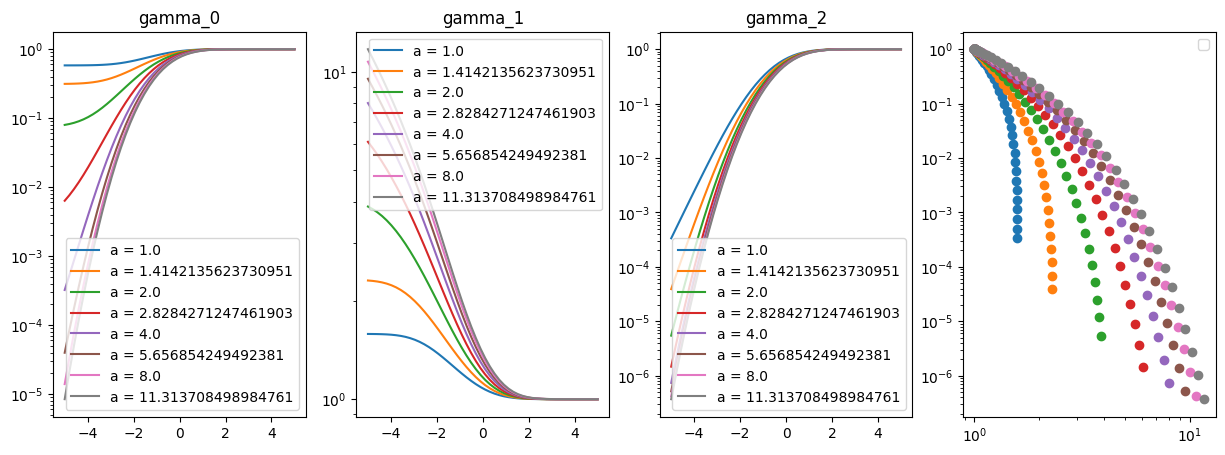

In [67]:
act = 'elu'
surrogate_fn = get_exact_function(act, )
# surrogate_fn = get_surrogate_function(act, )
# z_samples = np.random.standard_normal(1_000_000)
# surrogate_fn = get_monte_carlo_function(act, z_samples,)


import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for ai in np.arange(0, 4, 0.5):
    a = 2.0**ai
    bs = np.linspace(-5,5,50)
    Gs = []
    for b in bs:
        gs = surrogate_fn(a=a, b=b)
        Gs.append(gs)
    
    g0,g1,g2 = zip(*Gs)
    for gi,g in enumerate([g0,g1,g2]):
        axes[gi].plot(bs, g, label=f'a = {a}')
        axes[gi].set_title(f'gamma_{gi}')
        axes[gi].set_yscale('log')
        axes[gi].legend()
    axes[3].scatter(np.array(g1),g2)
    axes[3].set_xscale('log')
    axes[3].set_yscale('log')
    # axes[0].plot(bs, g0, label=f'$\\gamma_0$, a = {a}')
    # axes[1].plot(bs, g1, label=f'$\\gamma_1$, a = {a}')
    # axes[2].plot(bs, g2, label=f'$\\gamma_1$, a = {a}')
plt.legend()

In [21]:
a, b = 10.0, -5.
act = 'elu'
fn = get_surrogate_function(act, )
%timeit gs = fn(a=a, b=b)
fn = get_exact_function(act, )
%timeit gs = fn(a=a, b=b)
surrogate_fn = get_monte_carlo_function(act, z_samples,)
%timeit gs = fn(a=a, b=b)


102 μs ± 1.29 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.19 ms ± 4.31 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.19 ms ± 16.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
